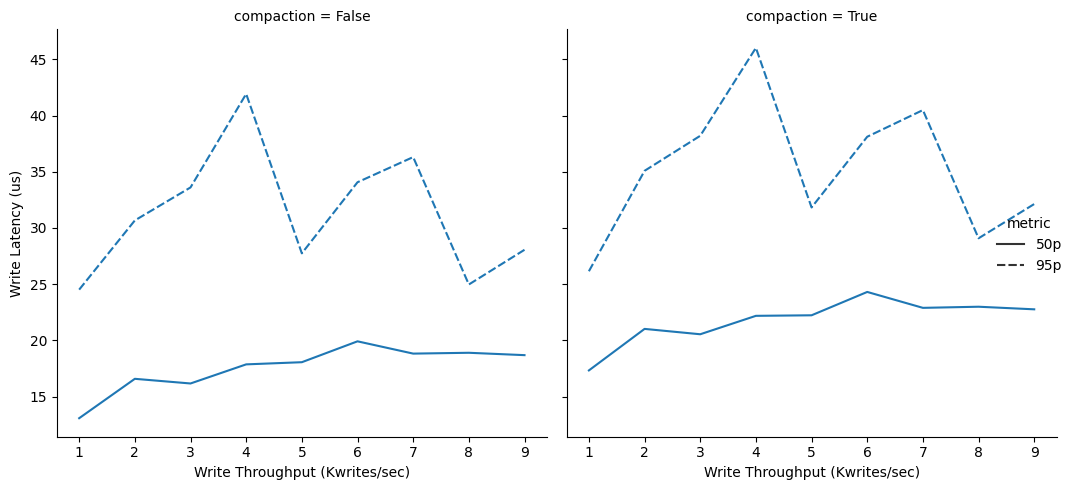

In [1]:
# writes

import sys
from numpy import percentile
from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote
from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer
from utils import run


def measure_compaction(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    writes_per_secs = list(range(1_000, 10_000, 1_000))

    for writes_per_sec in writes_per_secs:
        latencies = []
        for i in range(seconds):
            # pick key/values to write
            with Timer() as latency:
                for _ in range(writes_per_sec):
                    db[keys_set[next(distro)]] = vals_set[next(distro)]
            latency = float(latency)
            avg_latency = latency / writes_per_sec
            # if latency < 1:
            #     sleep(1 - latency)
            latencies.append(avg_latency)

        res.append({'metric': '50p', 'value': percentile(latencies, 50), 'writes_per_sec': writes_per_sec/1000})
        res.append({'metric': '95p', 'value': percentile(latencies, 95), 'writes_per_sec': writes_per_sec/1000})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [AppendLog], [{
        'max_runs_per_level': [3],
        'threshold': [1000],
        'compaction': [False, True],
        'remote': [None]
    }],
    [measure_compaction], {}
)


data = df[['compaction', 'writes_per_sec', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000   #us

relplot(data=data, x='writes_per_sec', y='value', col='compaction',
        style='metric', filename='compaction_write.pdf',
        xlabel='Write Throughput (Kwrites/sec)', ylabel='Write Latency (us)')

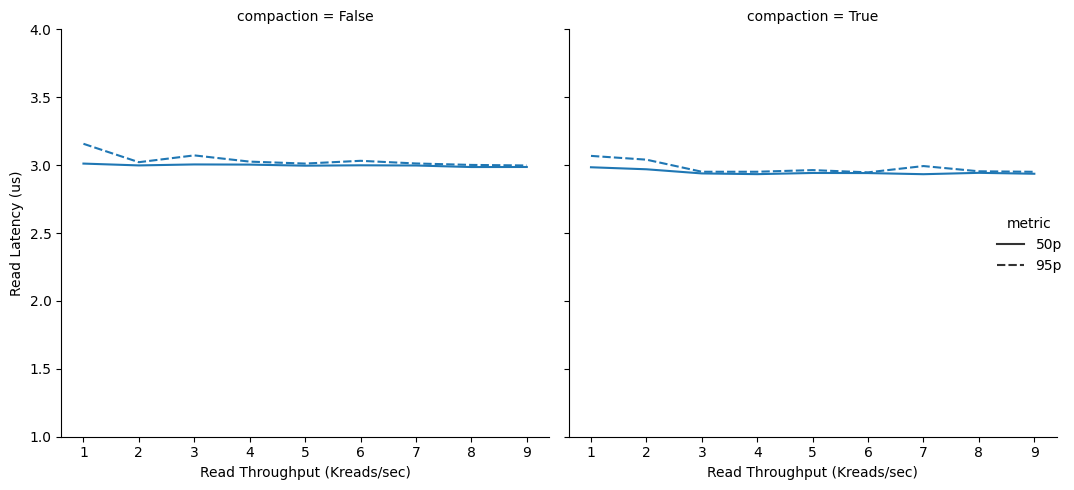

In [6]:
# reads

import sys
from numpy import percentile
from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote
from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer
from utils import run


def measure_compaction(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    reads_per_secs = list(range(1_000, 10_000, 1_000))

    # first populate
    for k, v in zip(keys_set, vals_set):
        db[k] = v

    for reads_per_sec in reads_per_secs:
        latencies = []
        for i in range(seconds):
            with Timer() as latency:
                for _ in range(reads_per_sec):
                    _ = db[keys_set[next(distro)]]
            latency = float(latency)
            avg_latency = latency / reads_per_sec
            # if latency < 1:
            #     sleep(1 - latency)
            latencies.append(avg_latency)

        res.append({'metric': '50p', 'value': percentile(latencies, 50), 'reads_per_sec': reads_per_sec/1000})
        res.append({'metric': '95p', 'value': percentile(latencies, 95), 'reads_per_sec': reads_per_sec/1000})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [AppendLog], [{
        'max_runs_per_level': [3],
        'threshold': [1000],
        'compaction': [False, True],
        'remote': [None]
    }],
    [measure_compaction], {}
)


data = df[['compaction', 'reads_per_sec', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000   #us

relplot(data=data, x='reads_per_sec', y='value', col='compaction',
        style='metric', filename='compaction_read.pdf',
        ylim=(1, 4),
        xlabel='Read Throughput (Kreads/sec)', ylabel='Read Latency (us)')